In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
%matplotlib inline
import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import random

from sklearn.decomposition import PCA
import os
import cv2
import onnxruntime
from collections import Counter
import imgaug.augmenters as iaa
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

logging.getLogger().setLevel(logging.INFO)

In [5]:
plt.rcParams["figure.figsize"] = (20,20)

In [4]:
CL_MEAN = np.asarray([[0.485, 0.456, 0.406]], dtype=np.float32)
CL_STD = np.asarray([[0.229, 0.224, 0.225]], dtype=np.float32)


### Image preproces

In [25]:
def preprocess(image, shape):
    img_in = cv2.resize(image, shape, interpolation=cv2.INTER_LINEAR)  # resize
    img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)  # convert to RGB

    img_in = img_in.astype(np.float32) / 255.0
    img_in = (img_in - CL_MEAN) / CL_STD
    img_in = np.transpose(img_in, (2, 0, 1))
    # img_in = img_in.astype(np.float16)
    return img_in


### Image augmantation (rotation etc)

In [125]:
def augment_image(image):
    aug_list = [[iaa.GaussianBlur(3), iaa.Sharpen(1), iaa.SaltAndPepper(0.05)],  # Sharpen or blur
                #[iaa.Multiply(1.5), iaa.Multiply(0.5)],  # Make brighter or darker.
                [iaa.Affine(rotate=90), iaa.Affine(rotate=-90), iaa.Affine(rotate=180)]]  # Rotate
    images_aug = [image]
    for augs in aug_list:
        new_images = np.zeros_like([image])
        for aug in augs:
            aug_image = aug.augment_images(images_aug)
            new_images = np.concatenate([new_images, aug_image])
        images_aug += [i for i in new_images[1:]]
    return images_aug


### Load model (form https://github.com/PaddlePaddle/PaddleClas/blob/release/2.5/docs/en/quick_start/quick_start_recognition_en.md)

In [6]:
model = onnxruntime.InferenceSession('paddle_model.onnx', providers=['CPUExecutionProvider'])


In [7]:
model_input_name = model.get_inputs()[0].name
model_output_name = model.get_outputs()[0].name


### Function to apply model to image or list of images

In [28]:
def apply_emb_model(image, image_width=224, image_height=224):
    model_input = []
    if (not isinstance(image, list) or 
       (isinstance(image, np.ndarray) and len(image.shape) == 3)):
        image = [image]
    for img in image:
        # cv2.imshow('', img)
        # cv2.waitKey(0)
        img_in = preprocess(img, (image_width, image_height))
        img_in = np.ascontiguousarray(img_in)
        model_input.append(img_in)

    onnx_input_image = {model_input_name: model_input}
    output, = model.run(None, onnx_input_image)
    return output


### Read train data and clean it

In [15]:
# read text file into pandas DataFrame
train_df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep=" ", 
                       names=['path', 'class', 'subset', 'x1', 'y1', 'x2', 'y2', 'unknown'])

In [16]:
train_df = train_df.drop_duplicates(subset=['path', 'class'])

In [18]:
train_df = train_df[train_df.x1 < train_df.x2]

In [19]:
train_df = train_df[train_df.y1 < train_df.y2]

In [20]:
train_df.groupby(by=['class']).path.count()#.mean()

class
Adidas       30
Apple        30
BMW          30
Citroen      30
Cocacola     30
DHL          30
Fedex        30
Ferrari      30
Ford         30
Google       30
HP           30
Heineken     30
Intel        30
McDonalds    30
Mini         30
Nbc          30
Nike         30
Pepsi        30
Porsche      30
Puma         30
RedBull      29
Sprite       30
Starbucks    30
Texaco       30
Unicef       30
Vodafone     30
Yahoo        30
Name: path, dtype: int64

In [22]:
IMAGE_DIR = 'flickr_logos_27_dataset/flickr_logos_27_dataset_images'

### Create embedings form train images

In [29]:
base_emb = []
base_names = []
for i, row in train_df.iterrows():
    img = cv2.imread(os.path.join(IMAGE_DIR, row.path))
    img = img[row.y1:row.y2, row.x1:row.x2]
    base_emb.extend(apply_emb_model(img))
    base_names.append(row['class'])

In [32]:
base_emb = np.array(base_emb)
base_names = np.array(base_names)

### Load validation data and create embedings form images

In [33]:
# read text file into pandas DataFrame
val_df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep="	", 
                       names=['path', 'class'])

In [35]:
query_emb = []
query_names = []
for i, row in val_df.iterrows():
    if row['class'] != 'none':
        img = cv2.imread(os.path.join(IMAGE_DIR, row.path))
        query_emb.extend(apply_emb_model(img))
        query_names.append(row['class'])

In [36]:
query_emb = np.array(query_emb)
query_names = np.array(query_names)

### Find cosine similarity

In [37]:
sims = cosine_similarity(query_emb, base_emb)
print(sims.shape)

(135, 809)


### Metrics for most similar image

In [38]:
max_ids = np.argmax(sims, axis=1)

In [41]:
predicted_class = []
for i, id_ in enumerate(max_ids):
    predicted_class.append(base_names[id_])
predicted_class = np.asarray(predicted_class)

In [47]:
print(sum(query_names == predicted_class)/len(predicted_class))  # accuracy

0.5925925925925926


In [45]:
print(classification_report(query_names, predicted_class))

              precision    recall  f1-score   support

      Adidas       0.50      0.20      0.29         5
       Apple       0.80      0.80      0.80         5
         BMW       0.67      0.40      0.50         5
     Citroen       0.50      0.60      0.55         5
    Cocacola       0.33      0.20      0.25         5
         DHL       1.00      0.40      0.57         5
       Fedex       0.67      0.80      0.73         5
     Ferrari       0.36      0.80      0.50         5
        Ford       0.67      0.40      0.50         5
      Google       0.71      1.00      0.83         5
          HP       0.50      0.60      0.55         5
    Heineken       1.00      0.60      0.75         5
       Intel       0.43      0.60      0.50         5
   McDonalds       0.62      1.00      0.77         5
        Mini       0.50      0.80      0.62         5
         Nbc       1.00      0.60      0.75         5
        Nike       0.67      0.40      0.50         5
       Pepsi       0.33    

In [52]:
f1_score(query_names, predicted_class, average='micro')

0.5925925925925926

### Find best image number to classify  by f1 score

In [54]:
sort_ids = np.argsort(sims, axis=1)
sort_ids.shape

(135, 809)

In [120]:
f1_scores = []
n_samples = []
for n in range(1, 30):
    preds = []
    for i, ids in enumerate(sort_ids[:, -n:]):
        unique,pos = np.unique(base_names[ids],return_inverse=True) #Finds all unique elements and their positions
        counts = np.bincount(pos)                     #Count the number of each unique element
        maxpos = [k for k, c in enumerate(counts) if c == max(counts)]
        unique_sim = [] 
        for k in maxpos:
            unique_sim.append(np.mean([sims[i, ids[p_i]] for p_i, p in enumerate(pos) if p == k]))
        preds.append(unique[maxpos[np.argmax(unique_sim)]])
    f1_scores.append(f1_score(query_names, np.asarray(preds), average='macro'))
    n_samples.append(n)


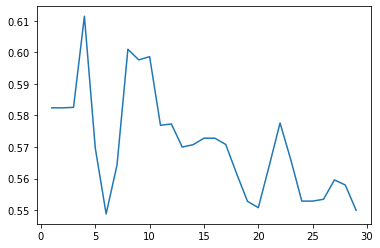

In [121]:
plt.plot(n_samples, f1_scores)

In [122]:
np.argmax(f1_scores)

3

In [123]:
f1_scores[3]

0.6114632281298947

###  Metrics for best image number: 3

In [180]:
predicted_class = []
all_unique_sim = []
for i, ids in enumerate(sort_ids[:, -3:]):
    unique,pos = np.unique(base_names[ids],return_inverse=True) #Finds all unique elements and their positions
    counts = np.bincount(pos)                     #Count the number of each unique element
    maxpos = [k for k, c in enumerate(counts) if c == max(counts)]
    unique_sim = [] 
    for k in maxpos:
        unique_sim.append(np.mean([sims[i, ids[p_i]] for p_i, p in enumerate(pos) if p == k]))
    all_unique_sim.append(max(unique_sim))
    predicted_class.append(unique[maxpos[np.argmax(unique_sim)]])

In [138]:
print(classification_report(query_names, predicted_class))

              precision    recall  f1-score   support

      Adidas       0.50      0.20      0.29         5
       Apple       0.80      0.80      0.80         5
         BMW       0.60      0.60      0.60         5
     Citroen       0.50      0.60      0.55         5
    Cocacola       0.00      0.00      0.00         5
         DHL       1.00      0.40      0.57         5
       Fedex       0.44      0.80      0.57         5
     Ferrari       0.36      0.80      0.50         5
        Ford       0.67      0.40      0.50         5
      Google       0.83      1.00      0.91         5
          HP       0.50      0.60      0.55         5
    Heineken       1.00      0.40      0.57         5
       Intel       0.43      0.60      0.50         5
   McDonalds       0.62      1.00      0.77         5
        Mini       0.67      0.80      0.73         5
         Nbc       1.00      0.80      0.89         5
        Nike       0.67      0.40      0.50         5
       Pepsi       0.67    

### Find best image number to classify by accuracy

In [116]:
accuracies = []
n_samples = []
for n in range(1, 30):
    preds = []
    for i, ids in enumerate(sort_ids[:, -n:]):
        unique,pos = np.unique(base_names[ids],return_inverse=True) #Finds all unique elements and their positions
        counts = np.bincount(pos)                     #Count the number of each unique element
        maxpos = [k for k, c in enumerate(counts) if c == max(counts)]
        unique_sim = [] 
        for k in maxpos:
            unique_sim.append(np.mean([sims[i, ids[p_i]] for p_i, p in enumerate(pos) if p == k]))
        preds.append(unique[maxpos[np.argmax(unique_sim)]])
    accuracies.append(sum(query_names == np.asarray(preds))/len(predicted_class))
    n_samples.append(n)


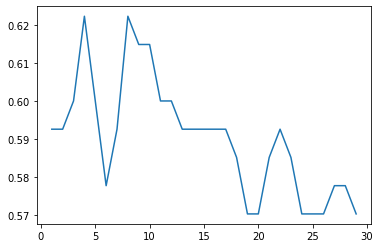

In [117]:
plt.plot(n_samples, accuracies)

In [119]:
np.argmax(accuracies)  # same number

3

### Create base embeding from augmented base images and chect if its better than base without augmantation

In [126]:
base_emb_aug = []
base_names_aug = []
for i, row in train_df.iterrows():
    img = cv2.imread(os.path.join(IMAGE_DIR, row.path))
    img = img[row.y1:row.y2, row.x1:row.x2]
    for im in augment_image(img):
        base_emb_aug.extend(apply_emb_model(im))
        base_names_aug.append(row['class'])

In [127]:
base_emb_aug = np.array(base_emb_aug)
base_names_aug = np.array(base_names_aug)

In [128]:
sims_aug = cosine_similarity(query_emb, base_emb_aug)
print(sims_aug.shape)
sort_ids_aug = np.argsort(sims_aug, axis=1)
sort_ids_aug.shape

(135, 12944)


(135, 12944)

In [158]:
f1_scores = []
n_samples = []
for n in range(1, 30):
    preds = []
    for i, ids in enumerate(sort_ids_aug[:, -n:]):
        unique,pos = np.unique(base_names_aug[ids],return_inverse=True) #Finds all unique elements and their positions
        counts = np.bincount(pos)                     #Count the number of each unique element
        maxpos = [k for k, c in enumerate(counts) if c == max(counts)]
        unique_sim = [] 
        for k in maxpos:
            unique_sim.append(np.mean([sims_aug[i, ids[p_i]] for p_i, p in enumerate(pos) if p == k]))
        preds.append(unique[maxpos[np.argmax(unique_sim)]])
    f1_scores.append(f1_score(query_names, np.asarray(preds), average='macro'))
    n_samples.append(n)


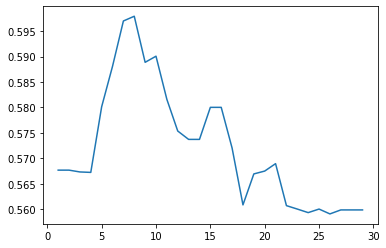

In [132]:
plt.plot(n_samples, f1_scores)

In [133]:
np.argmax(f1_scores)

7

In [134]:
f1_scores[7]

0.597944647944648

In [179]:
predicted_class = []
for i, ids in enumerate(sort_ids_aug[:, -3:]):
    unique, pos = np.unique(base_names_aug[ids],return_inverse=True) #Finds all unique elements and their positions
    counts = np.bincount(pos)                     #Count the number of each unique element
    maxpos = [k for k, c in enumerate(counts) if c == max(counts)]
    unique_sim = [] 
    for k in maxpos:
        unique_sim.append(np.mean([sims_aug[i, ids[p_i]] for p_i, p in enumerate(pos) if p == k]))
    predicted_class.append(unique[maxpos[np.argmax(unique_sim)]])
print(classification_report(query_names, predicted_class))

              precision    recall  f1-score   support

      Adidas       0.50      0.20      0.29         5
       Apple       0.62      1.00      0.77         5
         BMW       0.75      0.60      0.67         5
     Citroen       0.75      0.60      0.67         5
    Cocacola       0.25      0.20      0.22         5
         DHL       0.67      0.40      0.50         5
       Fedex       0.44      0.80      0.57         5
     Ferrari       0.44      0.80      0.57         5
        Ford       0.50      0.40      0.44         5
      Google       0.56      1.00      0.71         5
          HP       0.50      0.60      0.55         5
    Heineken       1.00      0.20      0.33         5
       Intel       0.38      0.60      0.46         5
   McDonalds       0.67      0.80      0.73         5
        Mini       0.50      0.80      0.62         5
         Nbc       1.00      0.80      0.89         5
        Nike       0.40      0.40      0.40         5
       Pepsi       0.50    

### Without augmantation is slightly better so save base for futher usage

In [136]:
with open('/home/user/Downloads/flickr_logos_27_dataset/flickr_logos_27_dataset_images/base_embeddings.npy', 'wb') as f:
    np.save(f, base_emb)
with open('/home/user/Downloads/flickr_logos_27_dataset/flickr_logos_27_dataset_images/base_names.txt', 'w') as f:
    for line in base_names:
        f.write(f"{line}\n")


### Confusion matrix

In [143]:
import seaborn as sns

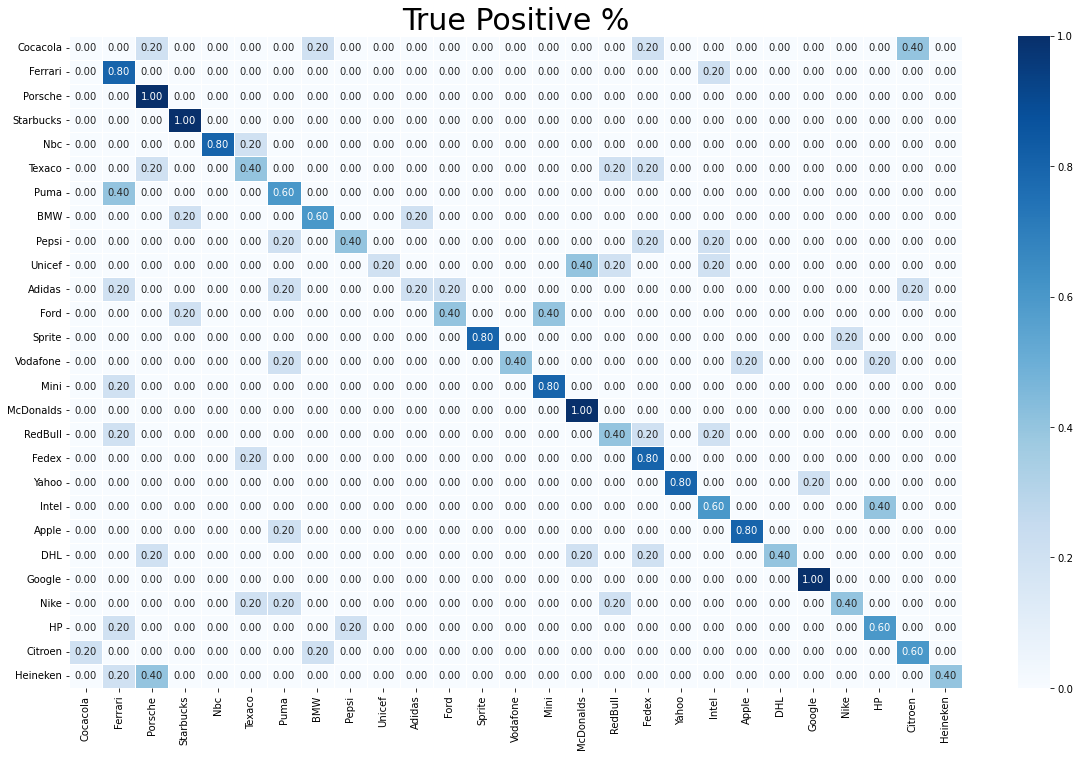

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(query_names, predicted_class, labels=list(set(query_names)), normalize='true')
df_cm = pd.DataFrame(cfn_matrix, index=list(set(query_names)), columns=list(set(query_names)))
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('True Positive %', fontsize=30)
plt.show()

### Investigate false prediction

In [177]:
pd.DataFrame({'correct': query_names == predicted_class, 'max_sim': all_unique_sim}).groupby(by=['correct']).describe()

max_sim                                                              \
          count      mean       std       min       25%       50%       75%   
correct                                                                       
False      54.0  0.253242  0.073270  0.131902  0.193056  0.253629  0.304568   
True       81.0  0.520307  0.200528  0.181231  0.362135  0.507245  0.674454   

                   
              max  
correct            
False    0.401451  
True     0.909963

Adidas Citroen 0.25268286


Adidas Ford 0.258815


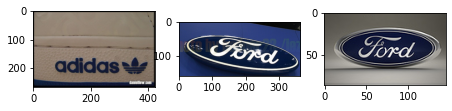

Adidas Puma 0.16506436


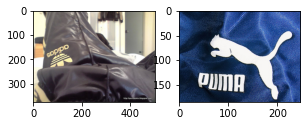

Adidas Ferrari 0.21214946


Apple Puma 0.2890846


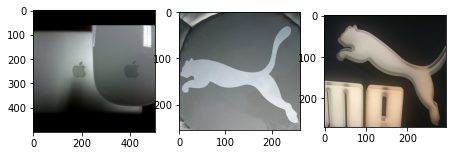

BMW Starbucks 0.2539625


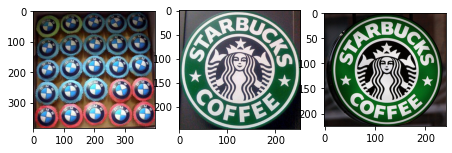

BMW Adidas 0.3491518


Citroen BMW 0.29949397


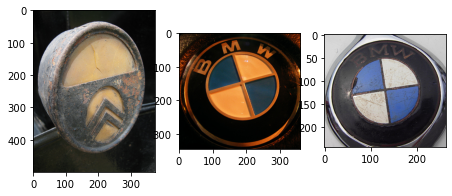

Citroen Cocacola 0.34587973


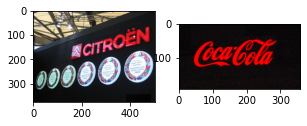

Cocacola Citroen 0.13847041


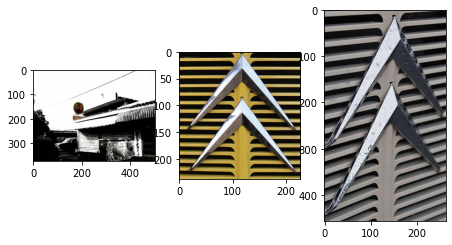

Cocacola Citroen 0.1411856


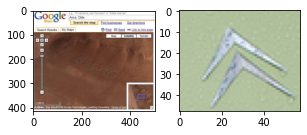

Cocacola Fedex 0.35093


Cocacola BMW 0.27640474


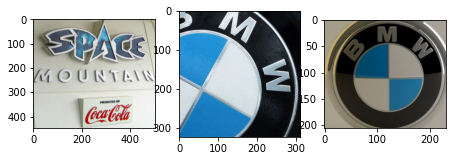

Cocacola Porsche 0.35086596


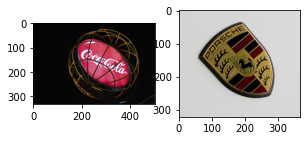

DHL Porsche 0.15558408


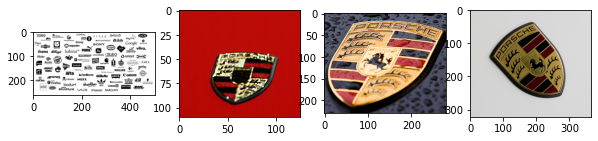

DHL Fedex 0.16787979


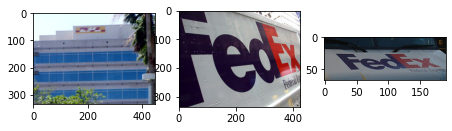

DHL McDonalds 0.26605704


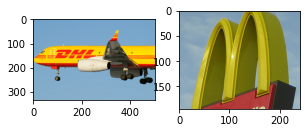

Fedex Texaco 0.16851741


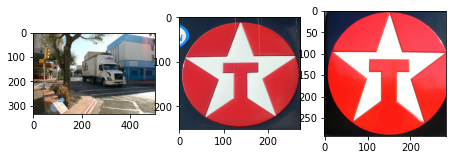

Ferrari Intel 0.1916059


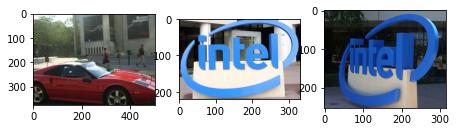

Ford Mini 0.2901163


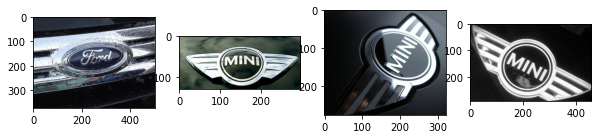

Ford Mini 0.39759618


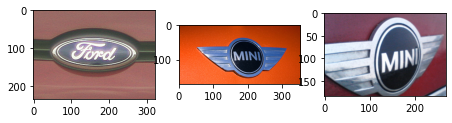

Ford Starbucks 0.28288424


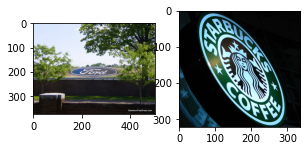

Heineken Porsche 0.23409158


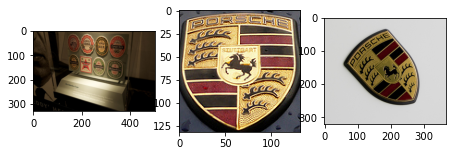

Heineken Porsche 0.24978073


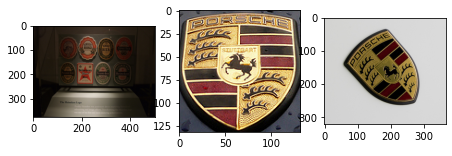

Heineken Ferrari 0.23357818


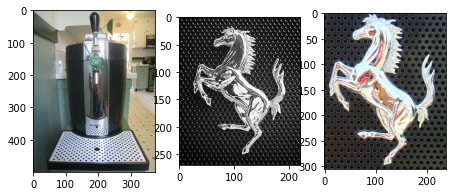

HP Ferrari 0.25456968


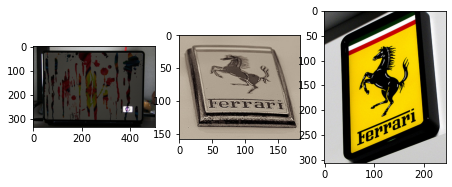

HP Pepsi 0.31227437


Mini Ferrari 0.23414405


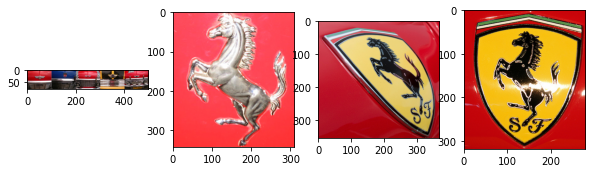

Nike RedBull 0.23453923


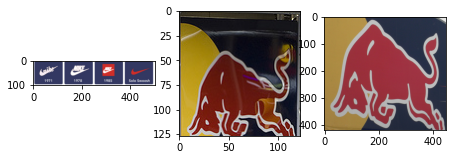

Nike Texaco 0.3022477


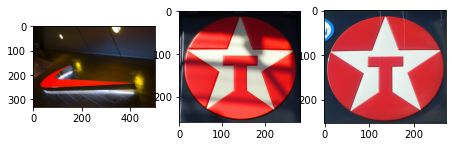

Nike Puma 0.19117114


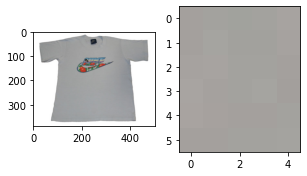

Pepsi Fedex 0.3353567


Pepsi Puma 0.15933579


Pepsi Intel 0.25329518


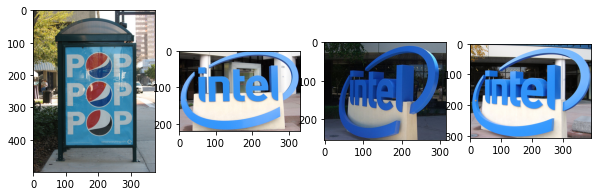

Puma Ferrari 0.2067755


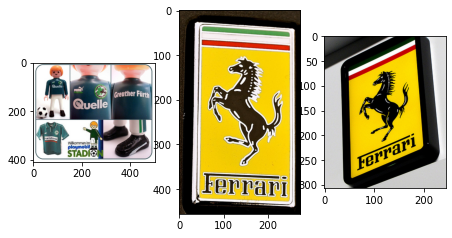

Puma Ferrari 0.21945219


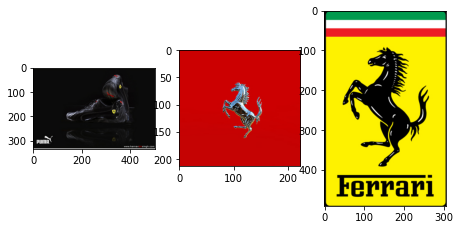

RedBull Intel 0.27682948


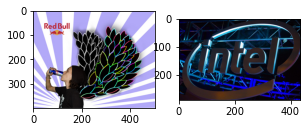

RedBull Fedex 0.19740552


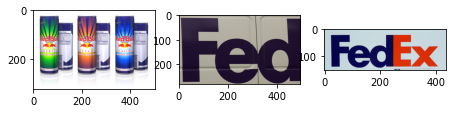

RedBull Ferrari 0.30534202


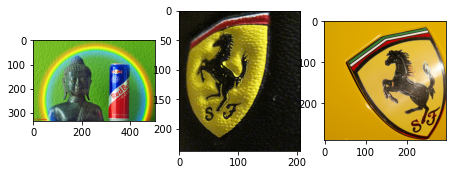

Sprite Nike 0.35434076


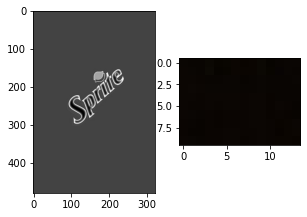

Intel HP 0.3331157


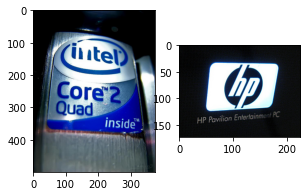

Intel HP 0.2554742


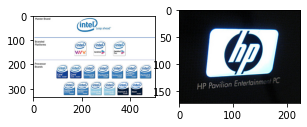

Texaco Fedex 0.16656649


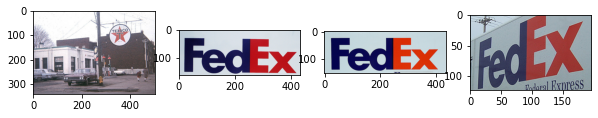

Texaco Porsche 0.23156697


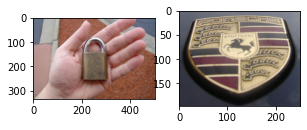

Texaco RedBull 0.14758499


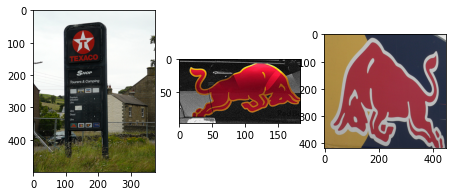

Unicef RedBull 0.17067473


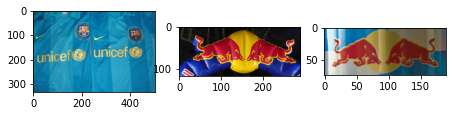

Unicef McDonalds 0.1388494


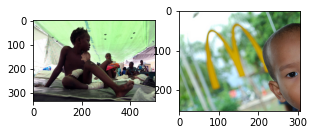

Unicef Intel 0.13190179


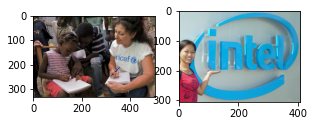

Unicef McDonalds 0.23518904


Vodafone HP 0.33686298


Vodafone Puma 0.4014507


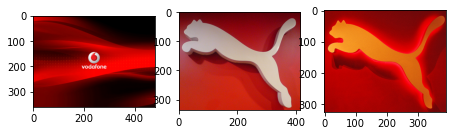

Vodafone Apple 0.3389393


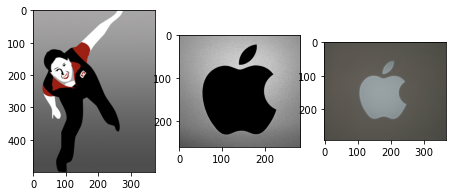

Yahoo Google 0.3713889


Nbc Texaco 0.25657332


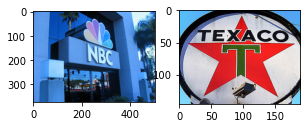

In [231]:
for i, ids in enumerate(sort_ids[:, -3:]):
    unique,pos = np.unique(base_names[ids],return_inverse=True) #Finds all unique elements and their positions
    counts = np.bincount(pos)                     #Count the number of each unique element
    maxpos = [k for k, c in enumerate(counts) if c == max(counts)]
    unique_sim = [] 
    for k in maxpos:
        unique_sim.append(np.mean([sims[i, ids[p_i]] for p_i, p in enumerate(pos) if p == k]))
    if unique[maxpos[np.argmax(unique_sim)]] != query_names[i]:
        print(query_names[i], unique[maxpos[np.argmax(unique_sim)]], max(unique_sim))
        fig, ax = plt.subplots(1, 1, figsize=(10, 40))
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.imread(os.path.join(IMAGE_DIR, val_df.iloc[i].path))[: ,:, ::-1])
        for k, id_ in enumerate([ids[p_i] for p_i, p in enumerate(pos) if p == maxpos[np.argmax(unique_sim)]]):
            plt.subplot(1, 4, 2 + k)
            plt.imshow(cv2.imread(os.path.join(IMAGE_DIR, train_df.iloc[id_].path))[train_df.iloc[id_].y1:train_df.iloc[id_].y2, 
                                                                                    train_df.iloc[id_].x1:train_df.iloc[id_].x2, ::-1])
        #break
        plt.show()

#### Most wrong results may couse by:
    - Low similarity score (most correct predictions above 0.5)
    - Similar logo color or texture
    - Similar logo shape
    - Base embeddings was created from croped logos but query images create from all image. So was comared all queris image with base not just logo
    - Simple embedder